In [28]:
import numpy as np 
rng = np.random.default_rng()

import pandas as pd

In [70]:
def plot_multiple_runs(data_model):
    groups = data_model.groupby("run")
    for _, g in groups:
        g.index = g["generation"]
        g["p"].plot(lw=.5, ylim=(0,1))

    data_model.groupby("generation")["p"].mean().plot(c="k", lw="1")

In [60]:
N = 100
p_0 = .5
D = 1.

In [61]:
# Create first generation
population = pd.DataFrame({"trait": rng.choice(["A", "B"], size=N, replace=True, p=[p_0, 1-p_0])})

In [62]:
# Create a DataFrame with a set of 3 randomly-picked demonstrators for each agent

demonstrators = pd.DataFrame({
    "dem1" : population["trait"].sample(N, replace=True).values,
    "dem2" : population["trait"].sample(N, replace=True).values,
    "dem3" : population["trait"].sample(N, replace=True).values
})

In [63]:
# Visualize the DataFrame
demonstrators

,dem1,dem2,dem3
0,B,B,A
1,A,B,A
2,A,B,B
3,B,A,B
4,B,B,B
...,...,...,...
95,A,B,A
96,B,B,A
97,B,B,B
98,B,A,B


In [64]:
# Get the number of A's in each 3-demonstrator combination
num_As = (demonstrators == "A").apply(sum, axis=1)
num_As

0     1
1     2
2     1
3     1
4     0
     ..
95    2
96    1
97    0
98    1
99    0
Length: 100, dtype: int64

In [65]:
# For 3-demonstrator combinations with all A's, set to A
population[ num_As == 3 ] = "A"
# For 3-demonstrator combinations with all B's, set to B
population[ num_As == 0 ] = "B"

In [66]:
prob_majority = rng.choice([True, False], p=[(2/3 + D/3), 1-(2/3 + D/3)], size=N, replace=True)
prob_minority = rng.choice([True, False], p=[(1/3 + D/3), 1-(1/3 + D/3)], size=N, replace=True)


In [67]:
# 3-demonstrator combinations with two As and one B
condition = prob_majority & (num_As == 2)
if condition.sum() > 0:
    population.loc[condition, "trait"] = "A"
condition = ~prob_majority & (num_As == 2)
if condition.sum() > 0:
    population.loc[condition, "trait"] = "B"

# 3-demonstrator combinations with two B's and one A
condition = ~prob_minority & (num_As == 1)
if condition.sum() > 0:
    population.loc[condition, "trait"] = "A"
condition = prob_minority & (num_As == 1)
if condition.sum() > 0:
    population.loc[condition, "trait"] = "B"


In [68]:
demonstrators["new_trait"] = population["trait"]
demonstrators

,dem1,dem2,dem3,new_trait
0,B,B,A,A
1,A,B,A,A
2,A,B,B,B
3,B,A,B,B
4,B,B,B,B
...,...,...,...,...
95,A,B,A,A
96,B,B,A,B
97,B,B,B,B
98,B,A,B,B


In [94]:
def conformist_transmission(N, p_0, D, t_max, r_max):
    # Create the output DataFrame
    output = pd.DataFrame({
        "generation" : np.tile(np.arange(t_max), r_max),
        "p" : [ np.nan ] * t_max * r_max,
        "run" : np.repeat(np.arange(r_max), t_max)
    })

    for r in range(r_max):
        # Create first generation
        population = pd.DataFrame({"trait": rng.choice(["A", "B"], size=N, replace=True, p=[p_0, 1 - p_0])})

        # Add first generation's p for run r
        output.loc[ r * t_max, "p"] = population[ population["trait"] == "A" ].shape[0] / N

        # For each generation 
        for t in range(1,t_max):
            demonstrators = pd.DataFrame({
                "dem1" : population["trait"].sample(N, replace=True).values,
                "dem2" : population["trait"].sample(N, replace=True).values,
                "dem3" : population["trait"].sample(N, replace=True).values
            })

            # Get the number of A's in each 3-demonstrator combination
            num_As = (demonstrators == "A").apply(sum, axis=1)

            # For 3-demonstrator combinations with all A's, set to A
            population[ num_As == 3 ] = "A"
            # For 3-demonstrator combinations with all A's, set to A
            population[ num_As == 3 ] = "A"
            # For 3-demonstrator combinations with all B's, set to B
            population[ num_As == 0 ] = "B"

            prob_majority = rng.choice([True, False], p=[(2/3 + D/3), 1-(2/3 + D/3)], size=N, replace=True)
            prob_minority = rng.choice([True, False], p=[(1/3 + D/3), 1-(1/3 + D/3)], size=N, replace=True)

            # 3-demonstrator combinations with two As and one B
            condition = prob_majority & (num_As == 2)
            if condition.sum() > 0:
                population.loc[condition, "trait"] = "A"
            condition = ~prob_majority & (num_As == 2)
            if condition.sum() > 0:
                population.loc[condition, "trait"] = "B"

            # 3-demonstrator combinations with two B's and one A
            condition = prob_minority & (num_As == 1)
            if condition.sum() > 0:
                population.loc[condition, "trait"] = "A"
            condition = ~prob_minority & (num_As == 1)
            if condition.sum() > 0:
                population.loc[condition, "trait"] = "B"
            
            # Get p and put it into output slot for this generation t and run r
            output.loc[r * t_max + t, "p"] = population[ population["trait"] == "A" ].shape[0] / N

    return output

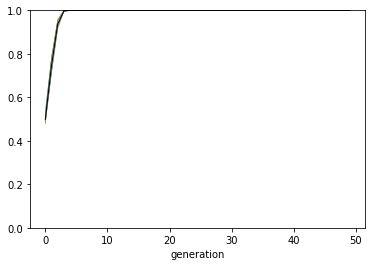

In [95]:
data_model = conformist_transmission(N=1_000, p_0 = 0.5, D = 1, t_max = 50, r_max = 10)
plot_multiple_runs(data_model)